In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=40198fe213f94b85638022e873bca3c5f008fd33216e34f5c7a826296c229d5a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from scipy.fft import fft
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import RFE
from lime import lime_tabular
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import shap

In [ ]:
# Define constants
DATADIR = '/content/drive/MyDrive/fan/id_00'
CATEGORIES = ['abnormal', 'normal']

In [ ]:
# Define functions for feature extraction
def zero_crossing_rate(audio_array):
    return len(np.where(np.diff(np.sign(audio_array)))[0])

def extract_time_domain_features(audio_array):
    mean = np.mean(audio_array)
    median = np.median(audio_array)
    variance = np.var(audio_array)
    std_dev = np.std(audio_array)
    skewness = skew(audio_array)
    kurt = kurtosis(audio_array)
    zero_cross_rate = np.mean(librosa.feature.zero_crossing_rate(audio_array))

    peaks, _ = find_peaks(audio_array)
    num_waves = len(peaks)
    wave_duration = len(audio_array) / (num_waves + 1) if num_waves > 0 else 0

    harmonic, percussive = librosa.effects.hpss(audio_array)
    pitches, magnitudes = librosa.core.piptrack(y=harmonic)
    pitches = pitches[magnitudes > np.median(magnitudes)]
    inst_freq = np.mean(librosa.hz_to_midi(pitches)) if len(pitches) > 0 else 0.0

    hjorth_params = librosa.feature.mfcc(y=audio_array, n_mfcc=13)
    mobility = np.mean(hjorth_params[1, :]) / np.mean(hjorth_params[0, :])
    activity = np.mean(hjorth_params[1, :])
    complexity = np.mean(hjorth_params[2, :])

    k_complex = np.sum(np.abs(np.diff(audio_array)) > 0.5)

    energy = np.sum(audio_array**2)

    return [mean, median, variance, std_dev, skewness, kurt, zero_cross_rate,
            num_waves, wave_duration, inst_freq, mobility, activity, complexity, k_complex, energy]

def extract_frequency_domain_features(audio_array):
    fft_result = fft(audio_array)
    freq_domain = np.abs(fft_result[:len(fft_result)//2])

    mean_freq = np.mean(freq_domain)
    median_freq = np.median(freq_domain)
    variance_freq = np.var(freq_domain)
    std_dev_freq = np.std(freq_domain)
    skewness_freq = skew(freq_domain)
    kurt_freq = kurtosis(freq_domain)

    delta = np.sum(freq_domain[(0 <= freq_domain) & (freq_domain <= 4)])
    theta = np.sum(freq_domain[(4 < freq_domain) & (freq_domain <= 8)])
    alpha = np.sum(freq_domain[(8 < freq_domain) & (freq_domain <= 13)])
    beta = np.sum(freq_domain[(13 < freq_domain) & (freq_domain <= 30)])
    gamma = np.sum(freq_domain[(30 < freq_domain) & (freq_domain <= 40)])
    sigma = np.sum(freq_domain[(40 < freq_domain) & (freq_domain <= 50)])

    zero_a = np.sum(freq_domain[(0 < freq_domain) & (freq_domain <= alpha)])
    b_a = np.sum(freq_domain[(beta < freq_domain) & (freq_domain <= alpha)])

    return [mean_freq, median_freq, variance_freq, std_dev_freq, skewness_freq, kurt_freq,
            delta, theta, alpha, beta, gamma, sigma, zero_a, b_a]

def create_training_data():
    training_data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for audio in os.listdir(path):
            audio_path = os.path.join(path, audio)
            audio_array, sr_array = librosa.load(audio_path, duration=30)

            time_features = extract_time_domain_features(audio_array)
            freq_features = extract_frequency_domain_features(audio_array)

            features = time_features + freq_features
            training_data.append([features, class_num])
    return training_data



In [ ]:
# Main script execution
if __name__ == "__main__":
    # Load and preprocess data
    training_data = create_training_data()
    X = [features for features, _ in training_data]
    y = [label for _, label in training_data]

    # Ensure consistent feature length
    max_length = max(len(features) for features in X)
    X_flat = [np.pad(features, (0, max_length - len(features))) for features in X]

    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train classifiers
classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'XGBoost': XGBClassifier(),
        'SVC': SVC(probability=True),
        'GaussianNB': GaussianNB(),
        'Random Forest': RandomForestClassifier()
}


In [ ]:
# Evaluate classifiers
results = {}
for name, clf in classifiers.items():
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        confusion_mat = confusion_matrix(y_test, y_pred)
        results[name] = {
            'classifier': clf,
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'confusion_matrix': confusion_mat
        }


Logistic Regression Results:
Accuracy: 0.795774647887324
F1 Score: 0.757686092737449
Precision: 0.8237864688128772
Recall: 0.795774647887324


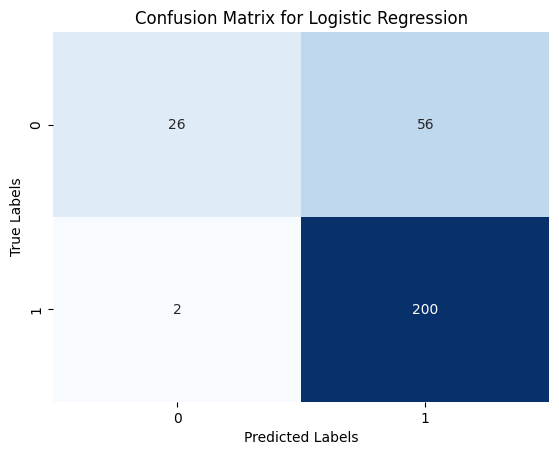


XGBoost Results:
Accuracy: 0.8063380281690141
F1 Score: 0.7812418542166155
Precision: 0.8133261105092092
Recall: 0.8063380281690141


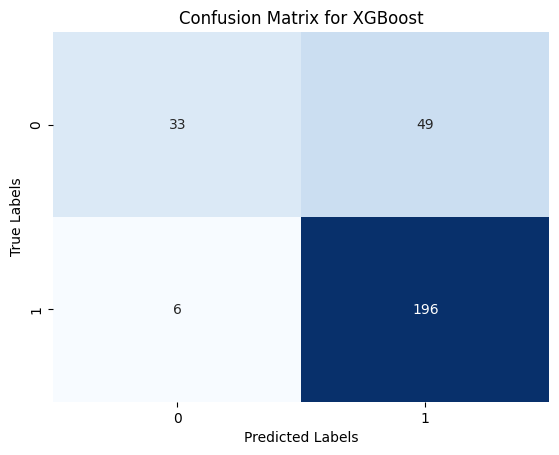


SVC Results:
Accuracy: 0.7992957746478874
F1 Score: 0.7582451344391281
Precision: 0.8434662026211323
Recall: 0.7992957746478874


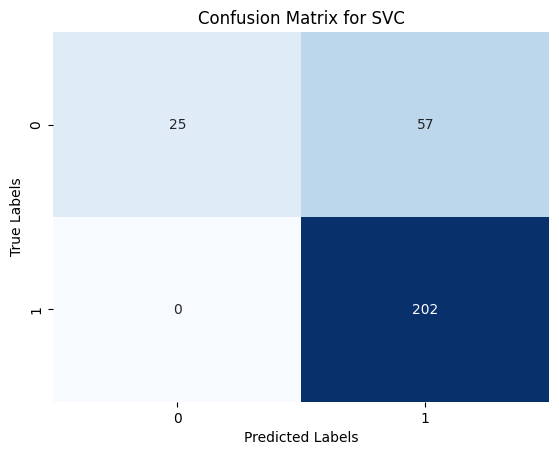


GaussianNB Results:
Accuracy: 0.7711267605633803
F1 Score: 0.7435248193279528
Precision: 0.7603605170115342
Recall: 0.7711267605633803


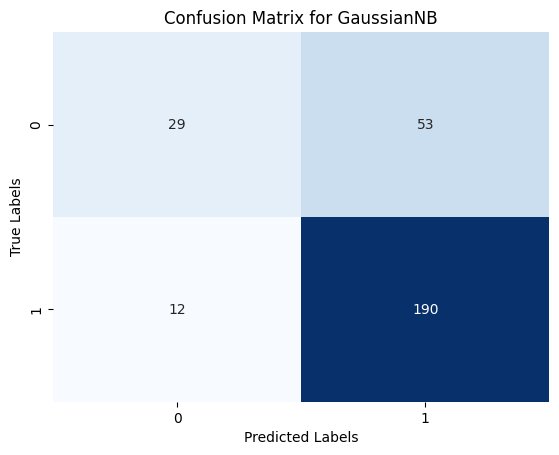


Random Forest Results:
Accuracy: 0.8098591549295775
F1 Score: 0.7825161136309381
Precision: 0.8245178959059013
Recall: 0.8098591549295775


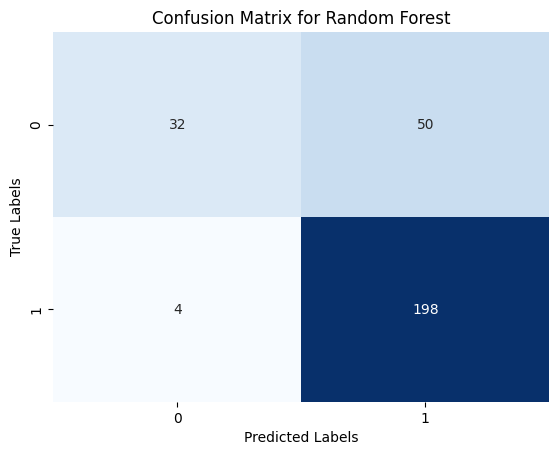

In [ ]:
# Display results
for name, result in results.items():
        print(f"\n{name} Results:")
        print(f"Accuracy: {result['accuracy']}")
        print(f"F1 Score: {result['f1_score']}")
        print(f"Precision: {result['precision']}")
        print(f"Recall: {result['recall']}")
        sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

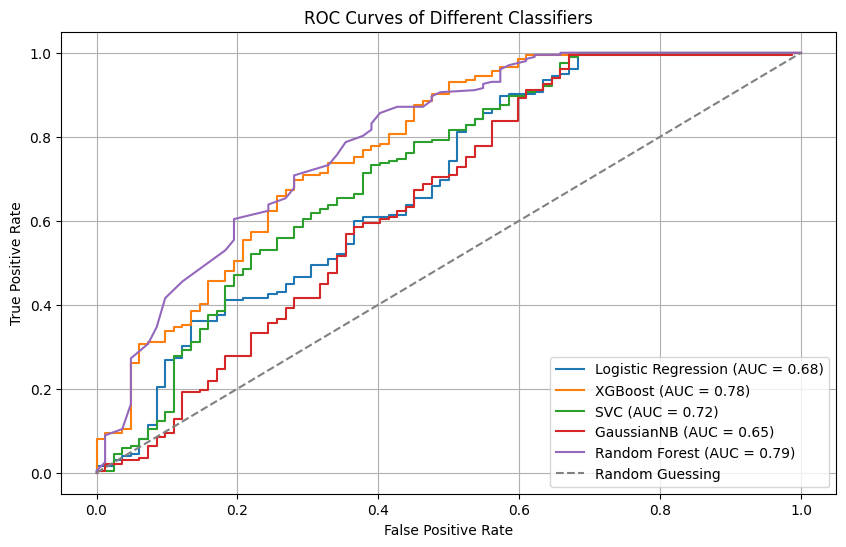

In [ ]:
# ROC Curve
plt.figure(figsize=(10, 6))
for name, result in results.items():
  clf = result['classifier']
  if hasattr(clf, "predict_proba"):
    y_scores = clf.predict_proba(X_test_scaled)[:, 1]
  else:
    y_scores = clf.decision_function(X_test_scaled)
  fpr, tpr, _ = roc_curve(y_test, y_scores)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Different Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

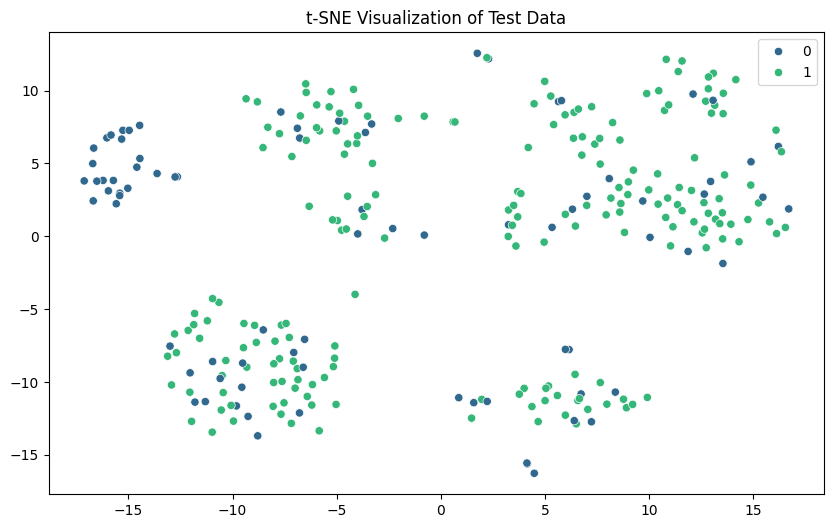

In [ ]:
# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=y_test, palette='viridis')
plt.title('t-SNE Visualization of Test Data')
plt.show()

In [ ]:
# LIME explanation
feature_names = ['mean', 'median', 'variance', 'std_dev', 'skewness', 'kurt', 'zero_cross_rate',
                     'num_waves', 'wave_duration', 'inst_freq', 'mobility', 'activity', 'complexity',
                     'k_complex', 'energy', 'mean_freq', 'median_freq', 'variance_freq', 'std_dev_freq',
                     'skewness_freq', 'kurt_freq', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'sigma',
                     'zero_a', 'b_a']
explainer = lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=feature_names, class_names=['abnormal', 'normal'], discretize_continuous=True)

explanation = explainer.explain_instance(X_test_scaled[0], classifiers['Random Forest'].predict_proba, num_features=10)
explanation.show_in_notebook()

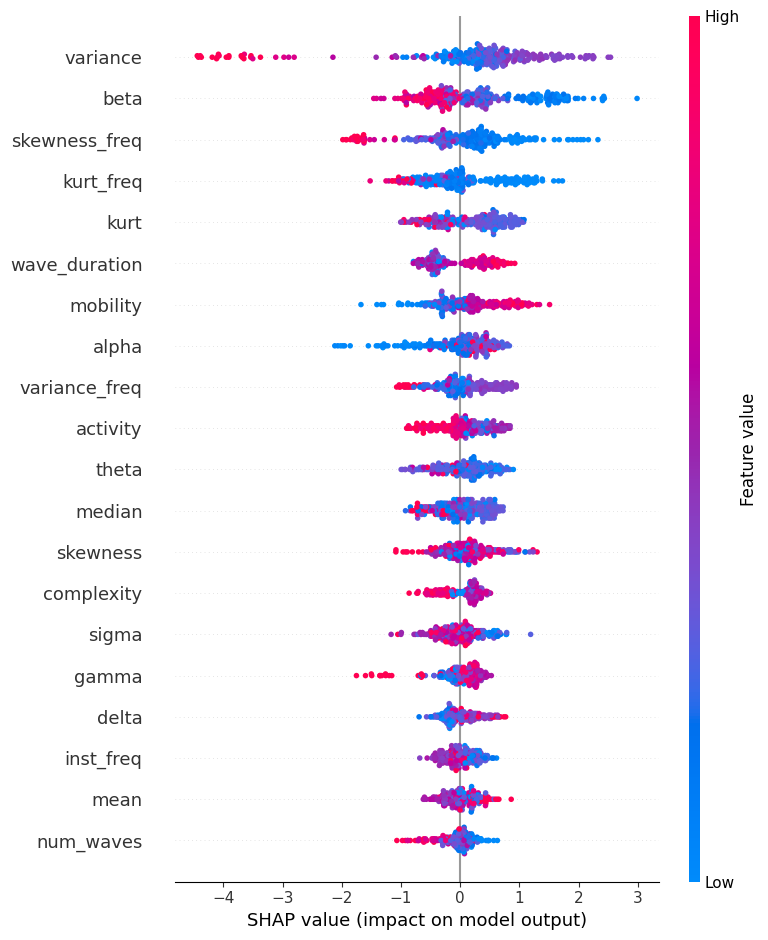

In [ ]:
# SHAP explanation for XGBoost
explainer_shap = shap.Explainer(classifiers['XGBoost'], X_train_scaled)
shap_values = explainer_shap(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

# Feature Selection Techniques
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

In [ ]:
# Compare models using PCA, LDA, RFE
for name, clf in classifiers.items():
  clf.fit(X_train_pca, y_train)
  y_pred_pca = clf.predict(X_test_pca)
  print(f"\n{name} with PCA Results:")
  print(classification_report(y_test, y_pred_pca))

  clf.fit(X_train_lda, y_train)
  y_pred_lda = clf.predict(X_test_lda)
  print(f"\n{name} with LDA Results:")
  print(classification_report(y_test, y_pred_lda))

  clf.fit(X_train_rfe, y_train)
  y_pred_rfe = clf.predict(X_test_rfe)
  print(f"\n{name} with RFE Results:")
  print(classification_report(y_test, y_pred_rfe))




Logistic Regression with PCA Results:
              precision    recall  f1-score   support

           0       0.93      0.32      0.47        82
           1       0.78      0.99      0.87       202

    accuracy                           0.80       284
   macro avg       0.85      0.65      0.67       284
weighted avg       0.82      0.80      0.76       284


Logistic Regression with LDA Results:
              precision    recall  f1-score   support

           0       0.90      0.32      0.47        82
           1       0.78      0.99      0.87       202

    accuracy                           0.79       284
   macro avg       0.84      0.65      0.67       284
weighted avg       0.81      0.79      0.75       284


Logistic Regression with RFE Results:
              precision    recall  f1-score   support

           0       0.87      0.32      0.46        82
           1       0.78      0.98      0.87       202

    accuracy                           0.79       284
   macro av